# Rotational preset embedder

> Class for a rotational preset embedder.

In [ ]:
#| default_exp models.embedding.rotational_preset_embedder

In [ ]:
#| export
from genQC.imports import *
from genQC.utils.math import gram_schmidt
from genQC.models.embedding.base_embedder import BaseEmbedder

## MultimodialEmbedder

In [ ]:
#| export
class MultimodialEmbedder(BaseEmbedder):
    
    def __init__(self, zero_sum_space: bool) -> None:
        super().__init__()

        self.zero_sum_space = zero_sum_space
        
        h_mean, h_std = torch.tensor(0.0), torch.tensor(1.0)
        w_mean, w_std = torch.tensor(0.0), torch.tensor(1.0)
        
        self.register_buffer('h_mean', h_mean)
        self.register_buffer('h_std', h_std)

        self.register_buffer('w_mean', w_mean)
        self.register_buffer('w_std', w_std)

    def set_scaling(self, h: torch.Tensor, w: torch.Tensor) -> None:
        self.h_mean, self.h_std = torch.tensor(0.0), torch.tensor(1.0)
        self.w_mean, self.w_std = torch.tensor(0.0), torch.tensor(1.0)

        return #disbled; not needed for new emb initialization
        
        x = self.embed(h, w)

        if not self.channel_last:
            x_h = x[:, :self.clr_dim]
            x_w = x[:, self.clr_dim:]
        else:
            x_h = x[..., :self.clr_dim]
            x_w = x[..., self.clr_dim:]
        
        self.h_mean, self.h_std = x_h.mean(), x_h.std()
        self.w_mean, self.w_std = x_w.mean(), x_w.std()
   
    def scale_emb(self, x_emb: torch.Tensor) -> torch.Tensor:
        # x_emb .. [b, ch, s, t]

        # mean
        if not self.zero_sum_space:
            if not self.channel_last:
                x_emb[:, :self.clr_dim] -= self.h_mean
                x_emb[:, self.clr_dim:] -= self.w_mean
            else:
                x_emb[..., :self.clr_dim] -= self.h_mean
                x_emb[..., self.clr_dim:] -= self.w_mean
        
        # variance
        if not self.channel_last:
            x_emb[:, :self.clr_dim] /= self.h_std
            x_emb[:, self.clr_dim:] /= self.w_std
        else:
            x_emb[..., :self.clr_dim] /= self.h_std
            x_emb[..., self.clr_dim:] /= self.w_std
              
        return x_emb

    def invert_scale_emb(self, x_emb: torch.Tensor) -> torch.Tensor:
        # x_emb .. [b, ch, s, t]

        # variance
        if not self.channel_last:
            x_emb[:, :self.clr_dim] *= self.h_std
            x_emb[:, self.clr_dim:] *= self.w_std
        else:
            x_emb[..., :self.clr_dim] *= self.h_std
            x_emb[..., self.clr_dim:] *= self.w_std

        # mean
        if not self.zero_sum_space:    
            if not self.channel_last:
                x_emb[:, :self.clr_dim] += self.h_mean
                x_emb[:, self.clr_dim:] += self.w_mean
            else:
                x_emb[..., :self.clr_dim] += self.h_mean
                x_emb[..., self.clr_dim:] += self.w_mean
        
        return x_emb

## MultimodialPresetEmbedder

In [ ]:
#| export
@dataclass
class MultimodialPresetEmbedderConfig:  
    clr_dim: int
    num_clrs: int
    params_dim: int
    num_params_per_clr: int
    zero_sum_space: bool
    explicit_node_type_embeddings: bool
    channel_last: bool
    parametrized_tokens: Optional[list[int]] = None 
    unique_class_values: Optional[list[int]] = None

In [ ]:
#| export
class MultimodialPresetEmbedder(MultimodialEmbedder):
    """
    Embedder class for multimodial discrete and continuous data, e.g. parametrized gates/actions. 
    Embeddings are fixed and not trained.
    """
    
    def __init__(self, 
                 clr_dim: int, 
                 num_clrs: int, 
                 params_dim: int, 
                 num_params_per_clr: int, 
                 zero_sum_space: bool,
                 explicit_node_type_embeddings: bool = True,
                 channel_last: bool = True,
                 parametrized_tokens: Optional[list[int]] = None,
                 unique_class_values: Optional[list[int]] = None) -> None:
        """
        Note `explicit_node_type_embeddings` means we convert the `+-k` to all postive, but there are often unsused connection types. For instance, `1=H` the minus node is never used.

        To improve this and reduce the `clr_dim`, we can provide `unique_values` which are the only tokens that actually appear.
        """
        super().__init__(zero_sum_space=zero_sum_space)


        if exists(unique_class_values):
            assert isinstance(unique_class_values, list)
            self.unique_class_values_tensor = torch.tensor(unique_class_values)
            
            explicit_node_type_embeddings = False

            print(f"[INFO]: provided `unique_class_values` ({unique_class_values}), enforcing `num_clrs=len(unique_class_values)={len(unique_class_values)}`.")
            num_clrs = len(unique_class_values)
        
        self.explicit_node_type_embeddings = explicit_node_type_embeddings  
        self.channel_last = channel_last
        self.parametrized_tokens = parametrized_tokens
        self.unique_class_values = unique_class_values

        if (num_params_per_clr*num_clrs) > params_dim and num_params_per_clr > 0:
            print(f"[WARNING]: For `num_params_per_clr` larger 0, we need at least a `params_dim` (is {params_dim}) of"
                  f" `num_params_per_clr*num_clrs` (is {num_params_per_clr*num_clrs}),"
                  f" automatically setting `params_dim` to {num_params_per_clr*num_clrs} to inforce this!")
        
            params_dim = num_params_per_clr*num_clrs

        if self.zero_sum_space and ((num_params_per_clr*num_clrs) + 1) > params_dim and num_params_per_clr > 0:
            print(f"[WARNING]: `params_dim` is set to the minimum `num_params_per_clr*num_clrs`={num_params_per_clr*num_clrs},"
                  f" but for `{zero_sum_space=}` we need one more dimension, automatically setting it to"
                  f" `num_params_per_clr*num_clrs+1` {num_params_per_clr*num_clrs+1}.")
            
            params_dim = num_params_per_clr*num_clrs + 1
        
        if self.zero_sum_space:        
            if self.explicit_node_type_embeddings and ((num_clrs*2 - 2) + 1) > clr_dim:
                print(f"[WARNING]: `clr_dim` is set to {clr_dim} and `{explicit_node_type_embeddings=}`,"
                      f" but for `{zero_sum_space=}` we need one more dimension than the number of tokens `(num_clrs*2 - 2)` (is {(num_clrs*2 - 2)}),"
                      f" automatically setting it to `clr_dim=(num_clrs*2 - 2) + 1` {(num_clrs*2 - 2) + 1}.")

                # has empty and padd tokens, these only have the plus branch (so -2)!
                clr_dim = (num_clrs*2 - 2) + 1

            elif (num_clrs + 1) > clr_dim:
                print(f"[WARNING]: `clr_dim` is set to {clr_dim} and `{explicit_node_type_embeddings=}`,"
                      f" but for `{zero_sum_space=}` we need one more dimension than the number of tokens `num_clrs` (is {num_clrs}),"
                      f" automatically setting it to `clr_dim=num_clrs+1` {num_clrs+1}.")
                
                clr_dim = num_clrs + 1
            
        self.clr_dim            = clr_dim
        self.num_clrs           = num_clrs
        self.params_dim         = params_dim
        self.num_params_per_clr = num_params_per_clr
        
        self._num_discrete_embeddings = self.num_clrs
        self._num_param_embeddings    = self.num_params_per_clr * self.num_clrs
        self.embedding_dim            = self.clr_dim + self.params_dim

        if self.explicit_node_type_embeddings:
            # use distinct embeddings for +-k and not just +-v
            # has empty and padd tokens, these only have the plus branch (so -2)!
            self._num_discrete_embeddings = self.num_clrs*2 - 2
     
        self.num_embeddings = self._num_discrete_embeddings + self._num_param_embeddings
        self.emb_clr        = nn.Embedding(num_embeddings=self.num_embeddings, embedding_dim=self.embedding_dim)    
        print(f"[INFO]: Created `nn.Embedding` with a total of {self.num_embeddings} vectors in a {self.embedding_dim} dimensional space.")
        
        self.params_config = MultimodialPresetEmbedderConfig(clr_dim=self.clr_dim, 
                                                             num_clrs=self.num_clrs, 
                                                             params_dim=self.params_dim, 
                                                             num_params_per_clr=self.num_params_per_clr,
                                                             zero_sum_space=self.zero_sum_space,
                                                             explicit_node_type_embeddings=self.explicit_node_type_embeddings,
                                                             channel_last=self.channel_last,
                                                             parametrized_tokens=self.parametrized_tokens)
        
        self._init_weights(zero_sum_space=self.zero_sum_space)
    
    def _init_weights(self, zero_sum_space) -> None:
        self.emb_clr.weight.requires_grad = False
        
        _dtype = self.emb_clr.weight.dtype
        self.emb_clr = self.emb_clr.to(torch.float64)
        
        # keep spaces ortho with clr
        self.emb_clr.weight.data.zero_()
        nn.init.orthogonal_(self.emb_clr.weight.data[:self._num_discrete_embeddings, :self.clr_dim])
        nn.init.orthogonal_(self.emb_clr.weight.data[self._num_discrete_embeddings:, self.clr_dim:])

        if zero_sum_space:
            assert self._num_discrete_embeddings < self.clr_dim, f"{self._num_discrete_embeddings} < {self.clr_dim}"
            if self._num_param_embeddings > 0:
                assert self._num_param_embeddings < self.params_dim, f"{self._num_param_embeddings} < {self.params_dim}"
 
            # Convert to zero-sum space
            self.emb_clr.weight.data[:self._num_discrete_embeddings, :self.clr_dim] -= torch.mean(self.emb_clr.weight.data[:self._num_discrete_embeddings, :self.clr_dim], dim=-1, keepdim=True) 
            if self._num_param_embeddings > 0:
                self.emb_clr.weight.data[self._num_discrete_embeddings:, self.clr_dim:] -= torch.mean(self.emb_clr.weight.data[self._num_discrete_embeddings:, self.clr_dim:], dim=-1, keepdim=True) 

            # Orthonormalization that conserves zero-sum space
            self.emb_clr.weight.data[:self._num_discrete_embeddings, :self.clr_dim] = gram_schmidt(self.emb_clr.weight.data[:self._num_discrete_embeddings, :self.clr_dim])
            if self._num_param_embeddings > 0:
                self.emb_clr.weight.data[self._num_discrete_embeddings:, self.clr_dim:] = gram_schmidt(self.emb_clr.weight.data[self._num_discrete_embeddings:, self.clr_dim:])
            
        self.emb_clr.weight.data[:self._num_discrete_embeddings, :self.clr_dim] /= torch.std(self.emb_clr.weight.data[:self._num_discrete_embeddings, :self.clr_dim], dim=-1, keepdim=True, correction=0)
        if self._num_param_embeddings > 0:
            self.emb_clr.weight.data[self._num_discrete_embeddings:, self.clr_dim:] /= torch.std(self.emb_clr.weight.data[self._num_discrete_embeddings:, self.clr_dim:], dim=-1, keepdim=True, correction=0)   
        
        self.emb_clr = self.emb_clr.to(_dtype)
        
    def print_emb_matrix(self) -> None:
        print(self.emb_clr.weight.data)

    #-----------------------------------------------

    def tokens_to_unique_class_values(self, x: torch.Tensor) -> torch.Tensor:
        if exists(self.unique_class_values):
            self.unique_class_values_tensor = self.unique_class_values_tensor.to(x.device)
            return torch.searchsorted(self.unique_class_values_tensor, x)
        return x

    def unique_class_values_to_tokens(self, x: torch.Tensor) -> torch.Tensor:
        if exists(self.unique_class_values):
            self.unique_class_values_tensor = self.unique_class_values_tensor.to(x.device)
            return self.unique_class_values_tensor[x]
        return x
    
    #-----------------------------------------------

    def embed_discrete(self, h: torch.Tensor) -> torch.Tensor:

        if self.unique_class_values:
            # tokens are already correct
            tokens = h 
            x_emb  = self.emb_clr(tokens)
        
        elif self.explicit_node_type_embeddings:
            # e.g. num_clrs=4: [-2, -1, zero, 1, 2, padd] to all positive  [0, 1, 2 (zero), 3, 4, 5 (padd)]
            tokens = h 
            x_emb  = self.emb_clr(tokens + (self.num_clrs-2))
        
        else:
            sign   = torch.sign(h + 0.1)  #trick: add 0.1 so that the sign of 0 is +1, else the 0 token would be all 0s.     
            tokens = torch.abs(h)
            
            x_emb = self.emb_clr(tokens)      
            x_emb = x_emb * sign.unsqueeze(-1)     # [b, s, t, ch]
        
        return x_emb, tokens
       

    def embed(self, h: torch.Tensor, w: torch.Tensor) -> torch.Tensor: 
        """
        sample from p(x0|h, w)
        h discrete
        w cont
        """

        x_emb, tokens = self.embed_discrete(h)

        v_p    = self.embed_continuous(w, tokens)          
        x_emb += v_p     

        if not self.channel_last:   
             # contiguous important for multi-node cluster     
            x_emb = torch.permute(x_emb, (0, 3, 1, 2)).contiguous() # to [b, ch, s, t]
     
        return x_emb
    
    #-----------------------------------------------

    def get_discrete_sim(self, x: torch.Tensor) -> torch.Tensor:
        #collaps clr to gate ... use cos sim
 
        clrs = self.emb_clr.weight.detach()[:self._num_discrete_embeddings] # is [clr_num, clr_dim]
        
        model_device = clrs.device
        x = x.to(model_device)
        
        # to shape [b*space*time, clr_dim]
        x_flat = x.reshape(-1, x.shape[-1])
                
        #normalize for cos sim       
        norm_clr    = F.normalize(  clrs[:, :self.clr_dim], dim=1) #clrs   / torch.linalg.vector_norm(  clrs, dim=1, keepdim=True) #torch.linalg.vector_norm(  clrs[:, :self.clr_dim], dim=1, keepdim=True) 
        norm_x_flat = F.normalize(x_flat[:, :self.clr_dim], dim=1) #x_flat / torch.linalg.vector_norm(x_flat, dim=1, keepdim=True) #torch.linalg.vector_norm(x_flat[:, :self.clr_dim], dim=1, keepdim=True) 
        
        #matmul out is [clr_num, b*space*time] =  [clr_num, clr_dim] x [b*space*time, clr_dim].T
        sim = torch.matmul(norm_clr, norm_x_flat.T) 

        return sim

    @torch.inference_mode()
    def invert_discrete(self, x: torch.Tensor, return_sim: bool = False, finite_temperature: bool = False) -> torch.Tensor:
        #collaps clr to gate ... use cos sim
 
        input_device = x.device

        if not self.channel_last:   
            x = x.permute(0, 2, 3, 1)
        
        #sim out is [clr_num, b*space*time]
        sim = self.get_discrete_sim(x)

        if self.explicit_node_type_embeddings or self.unique_class_values:
            #get highest similarity
            if finite_temperature:
                _cat = torch.distributions.categorical.Categorical(logits=sim.transpose(-1, -2))
                scores_flat = _cat.sample()
            else:
                scores_flat = torch.argmax(sim, dim=0) #reduce the clr_num dim

            if self.explicit_node_type_embeddings:
                scores_flat = scores_flat - (self.num_clrs-2)
            
        else:
            #get highest abs(similarity) and sign of it
            abs_sim = sim.abs()
            
            if finite_temperature:
                _cat = torch.distributions.categorical.Categorical(logits=abs_sim.transpose(-1, -2))
                max_idx = _cat.sample()
            else:
                max_idx = torch.argmax(abs_sim, dim=0) #reduce the clr_num dim
                
            sign = torch.sign(sim[max_idx, torch.arange(x_flat.shape[0])])
            scores_flat = max_idx * sign

        # back to [b, space, time]
        scores = scores_flat.reshape(x.shape[0], x.shape[1], x.shape[2]).to(torch.int64)      
        scores = scores.to(input_device)

        if return_sim:
            return scores, sim
        return scores

    @torch.inference_mode()
    def invert(self, x: torch.Tensor, reduce_spatial: bool = True) -> torch.Tensor: 
        """sample from p(h, w|x0)"""

        pred_tokens = self.invert_discrete(x)
        pred_params = self.invert_continuous(x, pred_tokens, reduce_spatial=reduce_spatial)

        pred_tokens = self.unique_class_values_to_tokens(pred_tokens)
        
        return pred_tokens, pred_params

    #-----------------------------------------------

    def _prepare_params(self, tokens: torch.Tensor, w: torch.Tensor) -> torch.Tensor:
        tokens = tokens.abs()

        # w ... [b, nP, s or 1, t]
        
        if self.parametrized_tokens:
            # Force all non parameterized embeddings to all zero or random lambdas !
            pmask = self.get_parametrized_mask(tokens).unsqueeze(1)     # [b, 1, s, t]     
            rnd_w = torch.zeros((w.shape[0], w.shape[1], pmask.shape[2], w.shape[3]), device=w.device)   
            w_m   = torch.where(pmask, w, rnd_w)
            
        else:
            # this does not include padding tokens!
            pmask = (tokens > 0).unsqueeze(1)
            w_m   = torch.where(pmask, w, 0.0) # ... [b, nP, s, t]
        
        return w_m

    def _reduce_params_spatial(self, tokens: torch.Tensor, params: torch.Tensor) -> torch.Tensor:
        tokens = tokens.abs()

        if self.parametrized_tokens:
            #check if not param gate
            mask = self.get_parametrized_mask(tokens).unsqueeze(1).float()  # ... [b, 1, s, t]
        else:
            #check if not empty token
            mask = (tokens > 0).unsqueeze(1).float() # ... [b, 1, s, t]

        # to catch all zero tokens at t, compute how many we have per timestep
        red_mask = mask.sum(-2) # ... [b, 1, t]
        red_mask = torch.where(red_mask > 0.0, red_mask, 1.0)
        
        params = (params*mask).sum(-2) / red_mask # ... [b, nP, s, t] to [b, nP, t]   average over s, ignore masked positions        
        return params

    def get_parametrized_mask(self, tokens: torch.Tensor) -> torch.Tensor:

        parametrized_tokens = torch.tensor(self.parametrized_tokens, device=tokens.device) 
        
        if exists(self.unique_class_values):
            parametrized_tokens = self.tokens_to_unique_class_values(parametrized_tokens)
  
        pmask = torch.isin(tokens.abs(), parametrized_tokens) 
  
        return pmask

### RotationalMultimodialPresetEmbedder

In [ ]:
#| export
class RotationalMultimodialPresetEmbedder(MultimodialPresetEmbedder):
    
    def __init__(self, 
                 clr_dim: int, 
                 num_clrs: int, 
                 params_dim: int, 
                 num_params_per_clr: int, 
                 zero_sum_space: bool,
                 explicit_node_type_embeddings: bool = True,
                 channel_last: bool = True,
                 parametrized_tokens: Optional[list[int]] = None,
                 unique_class_values: Optional[list[int]] = None
                ) -> None:

        self.channel_last = channel_last
        self.parametrized_tokens = parametrized_tokens
        
        if (2*num_params_per_clr*num_clrs) > params_dim and num_params_per_clr > 0:
            print(f"[WARNING]: We need at least a `params_dim` (is {params_dim}) of `2*num_params_per_clr*num_clrs` (is {2*num_params_per_clr*num_clrs}),"
                  f" automatically setting `params_dim` to {2*num_params_per_clr*num_clrs} to inforce this!")
        
            params_dim = 2*num_params_per_clr*num_clrs

        if zero_sum_space and (2*num_params_per_clr*num_clrs+1) > params_dim and num_params_per_clr > 0:
            print(f"[WARNING]: `params_dim` is set to the minimum `2*num_params_per_clr*num_clrs`={2*num_params_per_clr*num_clrs},"
                  f" but for `{zero_sum_space=}` we need one more dimension, automatically setting it to"
                  f" `2*num_params_per_clr*num_clrs+1` {2*num_params_per_clr*num_clrs+1}.")
            
            params_dim = 2*num_params_per_clr*num_clrs + 1
            
        super().__init__(clr_dim=clr_dim,
                         num_clrs=num_clrs,
                         params_dim=params_dim,
                         num_params_per_clr=2*num_params_per_clr,  # pass factor 2 to create more embeddings for cos-sin encoding
                         zero_sum_space=zero_sum_space,
                         explicit_node_type_embeddings=explicit_node_type_embeddings,
                         channel_last=channel_last,
                         parametrized_tokens=parametrized_tokens,
                         unique_class_values=unique_class_values) 

        self.num_params_per_clr    = num_params_per_clr   # remove the factor 2
        self._num_param_embeddings = self.num_params_per_clr * self.num_clrs 
        self.nP                    = num_params_per_clr

        self.params_config = MultimodialPresetEmbedderConfig(clr_dim=self.clr_dim, 
                                                             num_clrs=self.num_clrs, 
                                                             params_dim=self.params_dim, 
                                                             num_params_per_clr=self.num_params_per_clr,
                                                             zero_sum_space=self.zero_sum_space,
                                                             explicit_node_type_embeddings=self.explicit_node_type_embeddings,
                                                             channel_last=self.channel_last,
                                                             parametrized_tokens=self.parametrized_tokens,
                                                             unique_class_values=self.unique_class_values)

    
    def embed_continuous(self, w: torch.Tensor, tokens: torch.Tensor) -> torch.Tensor:
        # take care that v_empty stays that! not apply params to all bits only to a [s,t] pos
        # params ... [b, nP, t]
        # w      ...  qc=[b, nP, t]     mbqc=[b, nP, s, t]

        tokens = tokens.abs()
        
        if w.dim() == 3:
            w = w.unsqueeze(2) # to [b, nP, 1, t]


        w_m = self._prepare_params(tokens, w)
        
        w_m = w_m.unsqueeze(-1)  # ... [b, nP, s, t, 1]
        w_m = w_m * torch.pi     # [-1, 1] to [-pi, pi]

        # first pick starting points of indices
        # then add a numerator for all the number of paramters
        # then add a numerator for cos-sin vectors
        
        #Note: .view(-1, 1, 1) introduces some numeric variances in 1e-07 range, but should be faster!
        indices = self._num_discrete_embeddings + tokens * self.nP * 2                                    # ... [b, s, t]    
        indices = indices.unsqueeze(1) + torch.arange(self.nP, device=indices.device).view(-1, 1, 1) * 2  # ... [b, nP, s, t]
        indices = indices.unsqueeze(1) + torch.arange(2, device=indices.device).view(-1, 1, 1, 1)         # ... [b, 2, nP, s, t] 
        p_clrs  = self.emb_clr(indices).contiguous()                                                      # ... [b, 2, nP, s, t, ch]
    
        v_p = torch.cos(w_m)*p_clrs[:, 0] + torch.sin(w_m)*p_clrs[:, 1] # ... [b, nP, s, t, ch]
        v_p = torch.sum(v_p, dim=1)                                     # ... [b, s, t, ch]

        return v_p

    @torch.inference_mode()
    def invert_continuous(self, x: torch.Tensor, tokens: torch.Tensor, reduce_spatial: bool = True) -> torch.Tensor:
        """reduce_spatial=True for circuits, False for mbqc"""
        
        model_device = self.emb_clr.weight.device
        input_device = x.device

        if not self.channel_last:
            x = x.permute(0, 2, 3, 1)   # to [b,    s, t, ch]
        x = x.unsqueeze(1).unsqueeze(1)  # to [b, 1, 1, s, t, ch]
      
        x      = x.to(model_device) 
        tokens = tokens.to(model_device).abs()

        #-----
        # params should [b, nP, max_gates]
        # x      ... [b, ch, s, t] 
        # tokens ... [b,   , s, t] 

        #Note: .view(-1, 1, 1) introduces some numeric variances in 1e-07 range, but should be faster!
        indices = self._num_discrete_embeddings + tokens * self.nP * 2                                    # ... [b, s, t]    
        indices = indices.unsqueeze(1) + torch.arange(self.nP, device=indices.device).view(-1, 1, 1) * 2  # ... [b, nP, s, t]
        indices = indices.unsqueeze(1) + torch.arange(2, device=indices.device).view(-1, 1, 1, 1)         # ... [b, 2, nP, s, t] 
        p_clrs  = self.emb_clr(indices).contiguous()                                                      # ... [b, 2, nP, s, t, ch]

        overlaps = (x * p_clrs).sum(-1)                           # ... [b, 2, nP, s, t]
        params   = torch.arctan2(overlaps[:, 1], overlaps[:, 0])  # ... [b, nP, s, t]
        params   = params / torch.pi                              #  [-pi, pi] to [-1, 1]
           
        # now reduce spatial s, average over non empty token s
        if reduce_spatial:
            params = self._reduce_params_spatial(tokens, params)
               
        return params.to(input_device)

### RotationalMultimodialPresetEmbedderTiny

Has the same logic as `RotationalMultimodialPresetEmbedder`, but uses the same parameter vector-subspace for all tokens. This makes the parameter embeddings the same for all tokens while reducing the dimesionality of the embeddings, i.e. it is independent of the number of tokens.

In [ ]:
#| export
class RotationalMultimodialPresetEmbedderTiny(MultimodialPresetEmbedder):
    """Mostly the same as `RotationalMultimodialPresetEmbedder`, but the param embedding is not depending on the tokens."""
    
    def __init__(self, 
                 clr_dim: int, 
                 num_clrs: int,
                 params_dim: int, 
                 num_params_per_clr: int, 
                 zero_sum_space: bool,
                 explicit_node_type_embeddings: bool = True,
                 channel_last: bool = True,
                 parametrized_tokens: Optional[list[int]] = None,
                 unique_class_values: Optional[list[int]] = None
                ) -> None:
        super(MultimodialPresetEmbedder, self).__init__(zero_sum_space=zero_sum_space) # call grandparent class

        if exists(unique_class_values):
            assert isinstance(unique_class_values, list)
            self.unique_class_values_tensor = torch.tensor(unique_class_values)
            
            explicit_node_type_embeddings = False

            print(f"[INFO]: provided `unique_class_values` ({unique_class_values}), enforcing `num_clrs=len(unique_class_values)={len(unique_class_values)}`.")
            num_clrs = len(unique_class_values)
        
        self.zero_sum_space = zero_sum_space
        self.explicit_node_type_embeddings = explicit_node_type_embeddings  
        self.channel_last = channel_last
        self.parametrized_tokens = parametrized_tokens
        self.unique_class_values = unique_class_values
        # assert exists(parametrized_tokens)

        if (2*num_params_per_clr) > params_dim and num_params_per_clr > 0:
            print(f"[WARNING]: We need at least a `params_dim` (is {params_dim}) of `2*num_params_per_clr` (is {2*num_params_per_clr}),"
                  f" automatically setting `params_dim` to {2*num_params_per_clr} to inforce this!")
        
            params_dim = 2*num_params_per_clr

        if self.zero_sum_space and (2*num_params_per_clr+1) > params_dim and num_params_per_clr > 0:
            print(f"[WARNING]: `params_dim` is set to the minimum `2*num_params_per_clr`={2*num_params_per_clr},"
                  f" but for `{zero_sum_space=}` we need one more dimension, automatically setting it to"
                  f" `2*num_params_per_clr+1` {2*num_params_per_clr+1}.")
            
            params_dim = 2*num_params_per_clr + 1
       
        if self.zero_sum_space:
            if self.explicit_node_type_embeddings and ((num_clrs*2 - 2) + 1) > clr_dim:
                print(f"[WARNING]: `clr_dim` is set to {clr_dim} and `{explicit_node_type_embeddings=}`,"
                      f" but for `{zero_sum_space=}` we need one more dimension than the number of tokens `(num_clrs*2 - 2)` (is {(num_clrs*2 - 2)}),"
                      f" automatically setting it to `clr_dim=(num_clrs*2 - 2) + 1` {(num_clrs*2 - 2) + 1}.")

                # has empty and padd tokens, these only have the plus branch (so -2)!
                clr_dim = (num_clrs*2 - 2) + 1

            elif (num_clrs + 1) > clr_dim:
                print(f"[WARNING]: `clr_dim` is set to {clr_dim} and `{explicit_node_type_embeddings=}`,"
                      f" but for `{zero_sum_space=}` we need one more dimension than the number of tokens `num_clrs` (is {num_clrs}),"
                      f" automatically setting it to `clr_dim=num_clrs+1` {num_clrs+1}.")
                
                clr_dim = num_clrs + 1
  
        self.clr_dim            = clr_dim
        self.num_clrs           = num_clrs
        self.params_dim         = params_dim
        self.num_params_per_clr = num_params_per_clr
        self.nP                 = num_params_per_clr
     
        self._num_discrete_embeddings = self.num_clrs
        self._num_param_embeddings    = self.num_params_per_clr * 2
        self.embedding_dim            = self.clr_dim + self.params_dim
       
        if self.explicit_node_type_embeddings:
            # use distinct embeddings for +-k and not just +-v
            # has empty and padd tokens, these only have the plus branch (so -2)!
            self._num_discrete_embeddings = self.num_clrs*2 - 2
            
        self.num_embeddings = self._num_discrete_embeddings + self._num_param_embeddings 
        self.emb_clr        = nn.Embedding(num_embeddings=self.num_embeddings, embedding_dim=self.embedding_dim)    
        print(f"[INFO]: Created `nn.Embedding` with a total of {self.num_embeddings} vectors in a {self.embedding_dim} dimensional space.")
        
        self.params_config = MultimodialPresetEmbedderConfig(clr_dim=self.clr_dim, 
                                                             num_clrs=self.num_clrs, 
                                                             params_dim=self.params_dim, 
                                                             num_params_per_clr=self.num_params_per_clr,
                                                             zero_sum_space=self.zero_sum_space,
                                                             explicit_node_type_embeddings=self.explicit_node_type_embeddings,
                                                             channel_last=self.channel_last,
                                                             parametrized_tokens=self.parametrized_tokens,
                                                             unique_class_values=self.unique_class_values)
        
        self._init_weights(zero_sum_space=self.zero_sum_space)

    def embed_continuous(self, w: torch.Tensor, tokens: torch.Tensor) -> torch.Tensor:
        # take care that v_empty stays that! not apply params to all bits only to a [s,t] pos
        # params ... [b, nP, t]
        # w      ...  qc=[b, nP, t]     mbqc=[b, nP, s, t]

        tokens = tokens.abs()
        
        if w.dim() == 3:
            w = w.unsqueeze(2) # to [b, nP, 1, t]

        w_m = self._prepare_params(tokens, w)
            
        w_m = w_m.unsqueeze(-1)  # ... [b, nP, s, t, 1]
        w_m = w_m * torch.pi     # [-1, 1] to [-pi, pi]

        # first pick starting points of indices
        # then add a numerator for all the number of paramters
        # then add a numerator for cos-sin vectors
        
        #Note: .view(-1, 1, 1) introduces some numeric variances in 1e-07 range, but should be faster!
        indices = torch.full_like(tokens, self._num_discrete_embeddings)   #+ 0 * tokens * self.nP * 2                               # ... [b, s, t]    
        indices = indices.unsqueeze(1) + torch.arange(self.nP, device=indices.device).view(-1, 1, 1) * 2  # ... [b, nP, s, t]
        indices = indices.unsqueeze(1) + torch.arange(2, device=indices.device).view(-1, 1, 1, 1)         # ... [b, 2, nP, s, t] 
        p_clrs  = self.emb_clr(indices).contiguous()                                                      # ... [b, 2, nP, s, t, ch]

        # This cos-sin combination conserves mean and variance of the embeddings
        v_p = torch.cos(w_m)*p_clrs[:, 0] + torch.sin(w_m)*p_clrs[:, 1] # ... [b, nP, s, t, ch]
        v_p = torch.sum(v_p, dim=1)                                     # ... [b, s, t, ch]

        return v_p

    @torch.inference_mode()
    def invert_continuous(self, x: torch.Tensor, tokens: torch.Tensor, reduce_spatial: bool = True) -> torch.Tensor:
        """reduce_spatial=True for circuits, False for mbqc"""
        
        model_device = self.emb_clr.weight.device
        input_device = x.device

        if not self.channel_last:
            x = x.permute(0, 2, 3, 1)   # to [b,    s, t, ch]
        x = x.unsqueeze(1).unsqueeze(1)  # to [b, 1, 1, s, t, ch]
      
        x      = x.to(model_device) 
        tokens = tokens.to(model_device).abs()

        #-----
        # params should [b, nP, max_gates]
        # x      ... [b, ch, s, t] 
        # tokens ... [b,   , s, t] 

        #Note: .view(-1, 1, 1) introduces some numeric variances in 1e-07 range, but should be faster!
        indices = torch.full_like(tokens, self._num_discrete_embeddings) #+ 0 * tokens * self.nP * 2                                               # ... [b, s, t]    
        indices = indices.unsqueeze(1) + torch.arange(self.nP, device=indices.device).view(-1, 1, 1) * 2  # ... [b, nP, s, t]
        indices = indices.unsqueeze(1) + torch.arange(2, device=indices.device).view(-1, 1, 1, 1)         # ... [b, 2, nP, s, t] 
        p_clrs  = self.emb_clr(indices).contiguous()                                                      # ... [b, 2, nP, s, t, ch]

        # Note we dont need to normalize x as this norm cancels in  the fraction of arctan2(y/x)
        overlaps = (x * p_clrs).sum(-1)                           # ... [b, 2, nP, s, t]
        params   = torch.arctan2(overlaps[:, 1], overlaps[:, 0])  # ... [b, nP, s, t]
        params   = params / torch.pi                              #  [-pi, pi] to [-1, 1]
           
        # now reduce spatial s, average over non empty token s
        if reduce_spatial:
            params = self._reduce_params_spatial(tokens, params)

        return params.to(input_device)

## Test

### Encode decode check: fixed tensor

In [ ]:
s, t = 3, 8

rnd_tokens = torch.tensor([[[ 2, 0, 1, 0,  2, -3, 0,  8],
                            [-2, 4, 0, 5,  2,  3, 6,  8],
                            [ 2, 4, 0, 0, -2,  0, 0,  8]],
                          
                           [[ 8, 8, 1, 0,  2, -3, 0,  8],
                            [ 8, 8, 0, 7,  2,  3, 1,  8],
                            [ 8, 8, 8, 8,  8,  8, 8,  8]]])

rnd_params = torch.rand((2, 1, t))*2-1

In [ ]:
unique_class_values = None
unique_class_values = rnd_tokens.unique(sorted=True)

num_clrs = 9
num_params_per_clr = 1
parametrized_tokens = [5, 6, 7]

clr_dim    = 1
params_dim = 1

embedder = RotationalMultimodialPresetEmbedderTiny(clr_dim=clr_dim, 
                                               num_clrs=num_clrs, 
                                               params_dim=params_dim, 
                                               num_params_per_clr=num_params_per_clr,
                                               zero_sum_space=True,
                                               explicit_node_type_embeddings=True, 
                                               channel_last=True,
                                               parametrized_tokens=parametrized_tokens,
                                               unique_class_values=unique_class_values.tolist())

[INFO]: provided `unique_class_values` ([-3, -2, 0, 1, 2, 3, 4, 5, 6, 7, 8]), enforcing `num_clrs=len(unique_class_values)=11`.
[WARNING]: We need at least a `params_dim` (is 1) of `2*num_params_per_clr` (is 2), automatically setting `params_dim` to 2 to inforce this!
[WARNING]: `params_dim` is set to the minimum `2*num_params_per_clr`=2, but for `zero_sum_space=True` we need one more dimension, automatically setting it to `2*num_params_per_clr+1` 3.
[WARNING]: `clr_dim` is set to 1 and `explicit_node_type_embeddings=False`, but for `zero_sum_space=True` we need one more dimension than the number of tokens `num_clrs` (is 11), automatically setting it to `clr_dim=num_clrs+1` 12.
[INFO]: Created `nn.Embedding` with a total of 13 vectors in a 15 dimensional space.


In [ ]:
rnd_tokens, rnd_params

(tensor([[[ 2,  0,  1,  0,  2, -3,  0,  8],
          [-2,  4,  0,  5,  2,  3,  6,  8],
          [ 2,  4,  0,  0, -2,  0,  0,  8]],
 
         [[ 8,  8,  1,  0,  2, -3,  0,  8],
          [ 8,  8,  0,  7,  2,  3,  1,  8],
          [ 8,  8,  8,  8,  8,  8,  8,  8]]]),
 tensor([[[-0.0690,  0.7864,  0.9059,  0.3405,  0.9263, -0.5743,  0.6541,  0.8584]],
 
         [[-0.3695, -0.8219,  0.2678, -0.3850, -0.5806, -0.2786,  0.0526,  0.5283]]]))

In [ ]:
rnd_tokens_cls = embedder.tokens_to_unique_class_values(rnd_tokens)
rnd_tokens_cls

tensor([[[ 4,  2,  3,  2,  4,  0,  2, 10],
         [ 1,  6,  2,  7,  4,  5,  8, 10],
         [ 4,  6,  2,  2,  1,  2,  2, 10]],

        [[10, 10,  3,  2,  4,  0,  2, 10],
         [10, 10,  2,  9,  4,  5,  3, 10],
         [10, 10, 10, 10, 10, 10, 10, 10]]])

In [ ]:
enc_tensor = embedder.embed(rnd_tokens_cls, rnd_params)
print(enc_tensor.shape)

recon_tensor, recon_params = embedder.invert(enc_tensor, reduce_spatial=1)
recon_tensor, recon_params

torch.Size([2, 3, 8, 15])


(tensor([[[ 2,  0,  1,  0,  2, -3,  0,  8],
          [-2,  4,  0,  5,  2,  3,  6,  8],
          [ 2,  4,  0,  0, -2,  0,  0,  8]],
 
         [[ 8,  8,  1,  0,  2, -3,  0,  8],
          [ 8,  8,  0,  7,  2,  3,  1,  8],
          [ 8,  8,  8,  8,  8,  8,  8,  8]]]),
 tensor([[[ 0.0000,  0.0000,  0.0000,  0.3405,  0.0000,  0.0000,  0.6541,  0.0000]],
 
         [[ 0.0000,  0.0000,  0.0000, -0.3850,  0.0000,  0.0000,  0.0000,  0.0000]]]))

In [ ]:
assert torch.allclose(recon_tensor, rnd_tokens)
assert not torch.allclose(recon_params, rnd_params, atol=1e-06)   # note decoding puts 0s on all non param times, but we had rnd ones

pmask = embedder.get_parametrized_mask(embedder.tokens_to_unique_class_values(recon_tensor))
assert torch.allclose(torch.where(pmask.any(1, keepdim=True), recon_params, 0.0), torch.where(pmask.any(1, keepdim=True), rnd_params, 0.0), atol=1e-06)

### Encode decode check: random circuits

In [ ]:
from genQC.platform.simulation import Simulator, CircuitBackendType
from genQC.platform.tokenizer.circuits_tokenizer import CircuitTokenizer, Vocabulary
from genQC.platform.circuits_generation import get_rnd_encoded_circuits, CircuitConditionType
from genQC.dataset.balancing import get_tensor_gate_length

In [ ]:
g = ['h', 'cx', 'ccx', 'swap', 'rx', 'ry', 'cp']

simulator = Simulator(CircuitBackendType.QISKIT)
tokenizer = CircuitTokenizer({gi:i+1 for i,gi in enumerate(g)})
tokenizer.vocabulary

{'h': 1, 'cx': 2, 'ccx': 3, 'swap': 4, 'rx': 5, 'ry': 6, 'cp': 7}

In [ ]:
parametrized_tokens = CircuitTokenizer.get_parametrized_tokens(tokenizer.vocabulary)
parametrized_tokens

[5, 6, 7]

In [ ]:
def get_rnd_qc():
    tensors, ys, Us, params = get_rnd_encoded_circuits(backend=simulator.backend, 
                                                       tokenizer=tokenizer,
                                                       condition=CircuitConditionType.UNITARY,
                                                       samples=b,          
                                                       num_of_qubits=s, 
                                                       min_gates=2, 
                                                       max_gates=t,
                                                       min_sub_gate_pool_cnt=len(tokenizer.vocabulary),
                                                       optimized=False)
    
    l = get_tensor_gate_length(tensors, padding_token=0)
    for i, li in enumerate(l):    
        tensors[i, :, li:] = 8
    
    return tensors, ys, Us, params

In [ ]:
b    = 512
s, t = 4, 24

tensors, ys, Us, params = get_rnd_qc()
tensors[0]

  0%|          | 0/512 [00:00<?, ?it/s]

[INFO]: Generated unique circuits: 511.
[INFO]: No max_num_params provided, infered p_max_para=1, p_min_value=tensor(-0.9999) and p_max_value=tensor(0.9992).


tensor([[-3, -3,  0,  0,  4,  0, -2,  2,  0,  0,  0,  0,  0,  3,  0,  0,  0,  0, -3,  0,  4,  7, -3,  4],
        [-3,  3,  0,  0,  4,  0,  0, -2,  1,  7,  3,  0,  6,  0,  6,  0, -2,  7, -3,  0,  0,  7,  3,  0],
        [ 0, -3,  7,  5,  0,  1,  2,  0,  0,  0, -3,  4,  0, -3,  0,  1,  0,  7,  3,  0,  4,  0, -3,  0],
        [ 3,  0,  7,  0,  0,  0,  0,  0,  0,  7, -3,  4,  0, -3,  0,  0,  2,  0,  0,  5,  0,  0,  0,  4]], dtype=torch.int32)

In [ ]:
unique_class_values = None
unique_class_values = tensors.unique(sorted=True)

num_clrs = len(tokenizer.vocabulary) + 1 + 1
num_params_per_clr = 3 if "u" in g else 1

clr_dim    =1
params_dim = 1

embedder = RotationalMultimodialPresetEmbedderTiny(clr_dim=clr_dim, 
                                                   num_clrs=num_clrs, 
                                                   params_dim=params_dim, 
                                                   num_params_per_clr=num_params_per_clr,
                                                   zero_sum_space=True,
                                                   explicit_node_type_embeddings=True,
                                                   channel_last=True,
                                                   parametrized_tokens=parametrized_tokens, 
                                                   unique_class_values=unique_class_values.tolist())

[INFO]: provided `unique_class_values` ([-3, -2, 0, 1, 2, 3, 4, 5, 6, 7, 8]), enforcing `num_clrs=len(unique_class_values)=11`.
[WARNING]: We need at least a `params_dim` (is 1) of `2*num_params_per_clr` (is 2), automatically setting `params_dim` to 2 to inforce this!
[WARNING]: `params_dim` is set to the minimum `2*num_params_per_clr`=2, but for `zero_sum_space=True` we need one more dimension, automatically setting it to `2*num_params_per_clr+1` 3.
[WARNING]: `clr_dim` is set to 1 and `explicit_node_type_embeddings=False`, but for `zero_sum_space=True` we need one more dimension than the number of tokens `num_clrs` (is 11), automatically setting it to `clr_dim=num_clrs+1` 12.
[INFO]: Created `nn.Embedding` with a total of 13 vectors in a 15 dimensional space.


In [ ]:
tensors = embedder.tokens_to_unique_class_values(tensors)
tensors[0]

tensor([[0, 0, 2, 2, 6, 2, 1, 4, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 0, 2, 6, 9, 0, 6],
        [0, 5, 2, 2, 6, 2, 2, 1, 3, 9, 5, 2, 8, 2, 8, 2, 1, 9, 0, 2, 2, 9, 5, 2],
        [2, 0, 9, 7, 2, 3, 4, 2, 2, 2, 0, 6, 2, 0, 2, 3, 2, 9, 5, 2, 6, 2, 0, 2],
        [5, 2, 9, 2, 2, 2, 2, 2, 2, 9, 0, 6, 2, 0, 2, 2, 4, 2, 2, 7, 2, 2, 2, 6]])

In [ ]:
np.sqrt(embedder.clr_dim) 

np.float64(3.4641016151377544)

In [ ]:
#embedder single token clr mean:
for i in range(embedder._num_discrete_embeddings):
    a = embedder.emb_clr(torch.tensor([i]))[:, :embedder.clr_dim]
    print(f"token  {str(i):>2}:   mean {a.mean():0.3}   norm {torch.linalg.vector_norm(a):0.3}    std {a.std(correction=0):0.3}")

for i in range(embedder._num_param_embeddings):
    a = embedder.emb_clr(torch.tensor([embedder._num_discrete_embeddings+i]))[:, embedder.clr_dim:]
    print(f"params {str(i):>2}:   mean {a.mean():0.3}   norm {torch.linalg.vector_norm(a):0.3}    std {a.std(correction=0):0.3}")

token   0:   mean -1.49e-08   norm 3.46    std 1.0
token   1:   mean 4.97e-09   norm 3.46    std 1.0
token   2:   mean -1.49e-08   norm 3.46    std 1.0
token   3:   mean -2.48e-08   norm 3.46    std 1.0
token   4:   mean 0.0   norm 3.46    std 1.0
token   5:   mean 1.49e-08   norm 3.46    std 1.0
token   6:   mean -1.24e-09   norm 3.46    std 1.0
token   7:   mean 1.99e-08   norm 3.46    std 1.0
token   8:   mean 1.99e-08   norm 3.46    std 1.0
token   9:   mean -2.48e-09   norm 3.46    std 1.0
token  10:   mean 9.93e-09   norm 3.46    std 1.0
params  0:   mean -1.99e-08   norm 1.73    std 1.0
params  1:   mean -3.97e-08   norm 1.73    std 1.0


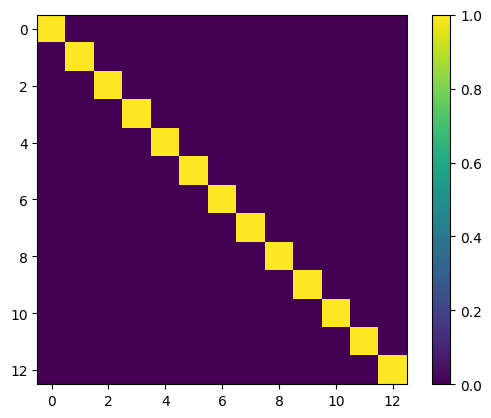

In [ ]:
#get scalar produkt of all
p = torch.zeros((embedder.num_embeddings, embedder.num_embeddings))
for i,j in itertools.product(range(embedder.num_embeddings), range(embedder.num_embeddings)):
    v1 = embedder.emb_clr(torch.tensor([i])) 
    v2 = embedder.emb_clr(torch.tensor([j]))
    p[i, j] = (v1 * v2).sum() / (torch.linalg.norm(v1)*torch.linalg.norm(v2))
    
plt.imshow(p)
plt.colorbar()
plt.show()

In [ ]:
#before normalization global scale
enc_tensor = embedder.embed(tensors, params)
enc_tensor.mean(), enc_tensor.std(correction=0)

(tensor(-7.4943e-09), tensor(1.))

In [ ]:
enc_tensor[..., :embedder.clr_dim].std(-1, correction=0).unique()

tensor([1.])

In [ ]:
enc_tensor[..., embedder.clr_dim:].std(-1, correction=0).unique()

tensor([1.0000, 1.0000, 1.0000, 1.0000])

In [ ]:
enc_tensor[..., :embedder.clr_dim].var(correction=0)

tensor(1.)

In [ ]:
recon_tensor, recon_params = embedder.invert(enc_tensor)

print(f"{tensors.shape=}")
print(f"{params.shape=}")
print((params-recon_params).abs().max())

assert torch.allclose(embedder.unique_class_values_to_tokens(tensors).long(), recon_tensor)
assert torch.allclose(params, recon_params, atol=1e-07)

tensors.shape=torch.Size([511, 4, 24])
params.shape=torch.Size([511, 1, 24])
tensor(5.9605e-08)


# Export -

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()